# Diomira NB

This notebook describes and shows the workings of the city of DIOMIRA, which simulates NEXT energy and tracking plane response (sensors and electronics).

authors: J.J. Gomez-Cadenas, V. Herrero and G. Martinez


In [1]:
import datetime

In [2]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-01-16 10:16:50


## DIOMIRA (Calvino, invisible cities)

Leaving there and proceeding for three days toward the east, you reach Diomira,
a city with sixty silver domes, bronze statues of all the gods, streets paved
with lead, a crystal theater, a golden cock that crows every morning on a
tower. All these beauties will already be familiar to the visitor, who has seen
them also in other cities. But the special quality of this city for the man who
arrives there on a September evening, when the days are growing shorter and the
multicolored lamps are lighted all at once at the doors of the food stalls and
from a terrace a woman's voice cries ooh!, is that he feels envy toward those
who now believe they have once before lived an evening identical to this and
who think they were happy, that time.

## The IC city of DIOMIRA

Diomira simulates the response of the energy plane and tracking plane sensors.

The response of the NEXT detector to ionizing radiation (e.g, an interaction produced by a bb decay or a background event such as a photon or alpha particle interaction) is, in general, an ionization trail. For example, a 2.5 MeV electron produced by a bb decay or a photoelectric interaction induced by a high-energy gamma produced in the Bi-214 chain, propagates by some 10-20 cm in dense gas (at a pressure of ~10 bar). Ionization electrons ejected through the electron path will drift towards the anode and will be amplified in the EL grid. Each ionization electron produces up to 1,000 photons (depending on EL field), which are emitted isotropically, thus reaching the sensors in the anode (SiPMs) and in the cathode (PMTs).

The input to DIMORA are the so-called Monte Carlo Raw Data (MCRD) files, produced by the NEXUS simulation. The MCRD files describe the "true response" of the NEXT sensors to the photon irradiation associated with an event. Photons are propagated through the chamber, and those reaching the sensors are eventually converted in a physical signal (photoelectrons or PES). The MCRD files contain vectors of PES for each sensor in the anode (tracking plane) and cathode (energy plane). The sampling rate in the PMTs of the energy plane is 1 ns (to allow a detailed simulation of the response of the front-end electronics, which runs at 40 MHz), while the sampling rate in the SiPMs is 1 mus, corresponding to the sampling rate of 1MHZ.

The response of the energy plane is simulated by the function:

**simulate_pmt_response(event, pmtrd)** which takes as arguments the event number and a vector of raw-data waveforms (input current in photoelectrons, sampled each ns, for each PMT in the energy plane). 

while the response of the tracking plane is simulated by the function:

**simulate_sipm_response(event, sipmrd, sipms_noise_sampler)** which takes as arguments the event number a vector of raw-data waveforms (input current in photoelectrons, sampled each mus, for each SiPM in the energy plane), and an instance of a noiser class that adds noise to each SiPM. 

Both functions are described below in more detail below.

The output of **simulate_pmt_response** is a vector of containing NPMT waveforms (where NPMT is the number of PMTs in the energy plane). Each waveform is a vector of (tipically) 48,000 samples, corresponding to a DAQ window of 1.2 ms at a sampling rate of 40 MHz. The RWFs represent the response of the energy plane front-end electronics (FEE) to the input photoelectron current. The RWF include the effect of the FEE (convolution with LPF and HPF filters), the effect of the DAQ (sampling at 25 ns), and add the noise of FEE and DAQ. The details of the simulation are described elswhere. 

The RWFs are stored in a 3D array called 
**pmtrwf([event] [npmt] [waveform])**
 

In addition to pmtwrf, function **simulate_pmt_response** also produces a vector **pmtblr([event] [npmt] [waveform])**. 

The so called basline restored (or BLR) waveforms correspond to the case of an ideal electronic which does not distort the input waveform (e.g, the photoelectron current). 

The output of **simulate_sipm_response** is a vector containing NSiPM waveforms (where NSiPM is the number of SiPMs in the tracking plane). Each waveform is a vector of (tipically) 1200 samples, corresponding to a DAQ window of 1.2 ms at a sampling rate of 1 MHz. This is stored in a 3D array called 
**sipmrwf([event] [npmt] [waveform])**



## simulate_pmt_response

1. Instances of **SPE** (single photoelectron) and **FEE** (front-end electronics) classes.

**spe = FE.SPE()**
       
**fee = FE.FEE(noise_FEEPMB_rms=FE.NOISE_I, noise_DAQ_rms=FE.NOISE_DAQ)**

2. Loop over all PMTs in the energy plane. For each PMT:

1. The input (true) current is computed as the convolution of the waveform of single photoelectrons (pmtrd) with the pulse (signal current) corresponding to a single photoelectron (SPE) 

**signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event, pmt])**

2. The effect of the DAQ is simulated, decimating the input signal

**signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)**

3. Effect of FEE and transform to adc counts

**signal_fee = FE.signal_v_fee(fee, signal_d, pmt) * FE.v_to_adc()**

4. Add noise daq
            
**signal_daq = cc * FE.noise_adc(fee, signal_fee)**

5. The RWF are baseline-shifted and sign-changed (to conform to data format)
**FE.OFFSET - signal_daq**

6. Compute BLR functions (LPF only no HPF)

Return a vector of RWF (one element per RWF) and a vector of BLR (one element per BLR)


## SiPM response

The simulation of the SiPM response simply adds noise (electronics and dark current noise) to the true photoelectrons and returns the total signal in adc counts

**dataSiPM = sipmrd[event] + sipms_noise_sampler.Sample()**

The noise sampler stores PDFs of each SiPM total noise. For each event those PDFs are sampled and the resulting noise added to the signal. 
        

In [3]:
from __future__ import print_function
import sys
import os
from glob import glob
from time import time

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math

In [5]:
import invisible_cities.core.tbl_functions as tbl
from invisible_cities.core.configure import configure, print_configuration
from invisible_cities.core.nh5 import FEE
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.core.wfm_functions as wfm
from invisible_cities.core.random_sampling\
     import NoiseSampler as SiPMsNoiseSampler
from invisible_cities.database import load_db
import invisible_cities.sierpe.fee as FE

In [6]:
from invisible_cities.cities.diomira import Diomira

In [7]:
import invisible_cities.sierpe.blr as blr

In [8]:
DataPMT = load_db.DataPMT()

## Run example configuration

### Configuration file

In [9]:
os.environ['IC_NOTEBOOK_DIR'] 

'/Users/jjgomezcadenas/Projects/ICNB/invisible_cities'

Below an example of configuration file for Diomira. The main variables to set are the input file path and name list (in the example a single file), the output path and file, print frequency, number of events to run and the noise cut (in pes) for the SiPMs. 

The noise cut is discussed later in the NB

In [10]:
conf_file= os.environ['IC_NOTEBOOK_DIR']  + '/config/diomira.conf'

### Input file for DIOMIRA

An example MCRD file, with 10 events, is added to the Notebooks repository

In [11]:
MCRD_file = os.environ['IC_NOTEBOOK_DIR']  + '/files/electrons_40keV_z250_MCRD.h5'

### Temporary file for the output of DIOMIRA

The output of Diomira must go to a temporary file that is deleted after execution (since the file can change many times it cannot be a stable file committed to the repository)

In [12]:
# This RWF file is produced as output of DIOMIRA. 
RWF_file= os.environ['IC_NOTEBOOK_DIR']  + '/files/electrons_40keV_z250_RWF_TMP.h5'

# era any previous temporary file
try:
    os.system("rm -f {}".format(RWF_file))
except(IOError):
    pass

### Running diomira

In [13]:
# function configure reads the configuration file and returns a dictionary of options
CFP = configure(['DIOMIRA','-c', conf_file, '-i', MCRD_file, '-o', RWF_file])

# init machine
fpp = Diomira()
# set machine state throught the parameters read from config file
files_in = glob(CFP['FILE_IN'])
files_in.sort()
fpp.set_input_files(files_in)
fpp.set_output_file(CFP['FILE_OUT'],
                        compression=CFP['COMPRESSION'])
fpp.set_print(nprint=CFP['NPRINT'])
fpp.set_sipm_noise_cut(noise_cut=CFP["NOISE_CUT"])

# run for nevts
nevts = CFP['NEVENTS'] if not CFP['RUN_ALL'] else -1
t0 = time()
nevt = fpp.run(nmax=nevts)
t1 = time()
dt = t1 - t0
print("DIOMIRA run {} evts in {} s, time/event = {}".\
      format(nevt, dt, dt/nevt))


COMPRESSION            => ZLIB4
FILE_IN                => /Users/jjgomezcadenas/Projects/ICNB/invisible_cities/files/electrons_40keV_z250_MCRD.h5
FILE_OUT               => /Users/jjgomezcadenas/Projects/ICNB/invisible_cities/files/electrons_40keV_z250_RWF_TMP.h5
INFO                   => False
NEVENTS                => 10
NOISE_CUT              => 20
NPRINT                 => 1
RUN_ALL                => False
SKIP                   => 0
VERBOSITY              => 20

                 DIOMIRA will run a max of 10 events
                 Input Files = ['/Users/jjgomezcadenas/Projects/ICNB/invisible_cities/files/electrons_40keV_z250_MCRD.h5']
                 Output File = /Users/jjgomezcadenas/Projects/ICNB/invisible_cities/files/electrons_40keV_z250_RWF_TMP.h5 (File) ''
Last modif.: 'Mon Jan 16 10:16:51 2017'
Object Tree: 
/ (RootGroup) ''

                          
Opening file /Users/jjgomezcadenas/Projects/ICNB/invisible_cities/files/electrons_40keV_z250_MCRD.h5
Events in file = 10
#

#### Diomira: speed and file size:

runs at: ~0.5 s/event on i-7 processor 3.5 Ghz (speed almost certainly limited by disk access)
files size

-rw-r--r--  1 jjgomezcadenas  staff   1.1M Jan 14 20:21 electrons_40keV_z250_MCRD.h5
-rw-r--r--  1 jjgomezcadenas  staff   1.5M Jan 15 10:03 electrons_40keV_z250_RWF.h5

MCRD files (produced by NEXUS MC): 110 kB/event
RWF files (output of DIOMIRA): 150 kB/event

##  Energy plane

### Comparison between BLR and CWF

The input to the simulation of the energy plane are MCRD waveform, e.g, vectors of photoelectrons sampled each ns. NEW has 12 PMTs (NEXT-100 has around 60). The DAQ window is tipically ~1.2 ms. Thus, MCRD vectors contain 1.2 M samples. Most of those samples are zero, however, and can be handled efficiently by a smart compressor. IC relies on the PyTable library to write data in hdf5 format. Several compressors are available and can be set at the configuration level. ZLIB at compression level 4 yields good results. 

Diomira reads the MCRD vectors and produces raw waveforms (RWF) sampled each 40 ns. The RWF reflect the effect of the LPF and HPF filters introduced by the front-end electronics (FEE). Diomira also produce BLR (baseline restored) waveforms, which simply add the LPF filter. BLRs correspond to the response of an ideal FEE which does not distort the waveform. 

CWF (corrected waveforms) are the result of passing a blr (base line restorarion) algorithm to the RWFs. If the blr algorithm is perfect, then CWF and BLR waveforms must be identical.

The algorithm below does the following:
1) Reads the RWF and BLR waveforms in the RWF file produced by the previous cell
2) Computes CWF files passing a blr algorithm.
3) Returns the differences (in area) between CWF and BLR

In [14]:
def diomira_cwf_blr(ffile, n_evt=10, plot=False):
    """ 1) Reads the RWF and BLR waveforms in the RWF file produced by the previous cell
        2) Computes CWF files passing a blr algorithm.
        3) Returns the differences (in area) between CWF and BLR
    """
    e40rwf= tb.open_file(ffile,'r+')
    pmtrwf = e40rwf.root.RD.pmtrwf
    pmtblr = e40rwf.root.RD.pmtblr
    DataPMT = load_db.DataPMT(0)
    coeff_c = DataPMT.coeff_c.values.astype(np.double)
    coeff_blr = DataPMT.coeff_blr.values.astype(np.double)
    
    DIFF = []
    for event in range(n_evt):
        if plot == True:
            mpl.plot_waveforms(pmtrwf[event], zoom=True, window_size=600)
            plt.show()
            # input('Raw waveforms: return to continue')
            mpl.plot_waveforms(pmtblr[event], zoom=True, window_size=600)
            plt.show()
            # input('BLR waveforms: return to continue')
            
        BLR = pmtblr[event]
        CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                     n_baseline=28000, thr_trigger=5)
        if plot == True:
            mpl.plot_blr_cwf(pmtblr[event], CWF, zoom=True, window_size=600)
            plt.show()
            #input('BLR vs CWF waveforms: return to continue')
            
        for i, _ in enumerate(CWF):
            diff = abs(np.sum(BLR[i][5000:5100]) - np.sum(CWF[i][5000:5100]))
            diff = 100. * diff/np.sum(BLR[i])
            DIFF.append(diff)
    return np.array(DIFF)

In [15]:
diff = diomira_cwf_blr(RWF_file, n_evt=10, plot=False)

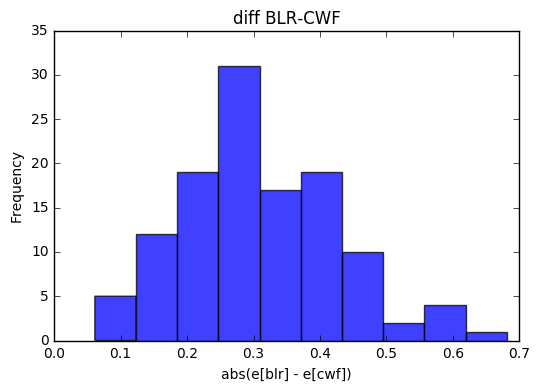

In [16]:
mpl.histo(diff, nbins=10, 
          title="diff BLR-CWF", xlabel="abs(e[blr] - e[cwf])", ylabel="Frequency")

The histogram above shows the difference (in %) between the BLR function (e.g, only the effect of LPF) and the CWF (e.g, corrected waveform). The CWF is the result of producing a RWF (through DIOMIRA) and then passing a baseline restoration algorithm. There are 12 entries (one per PMT) for each of the 10 events in the example file. The tipical difference in absolute value between the CWF and the BLR is of the order of 0.3 % and essentially never larger than 0.5 %. The data is 40 keV electrons, corresponding to the energy range of kripton signals. 

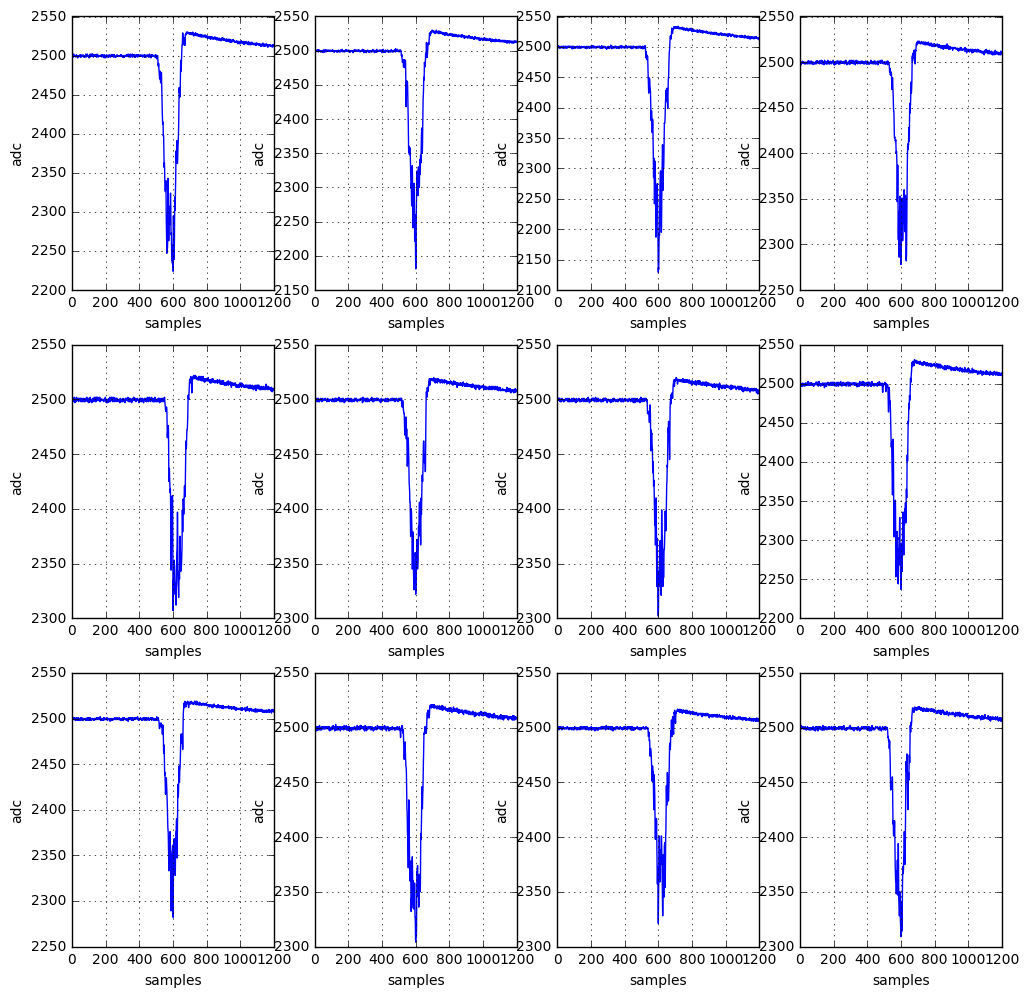

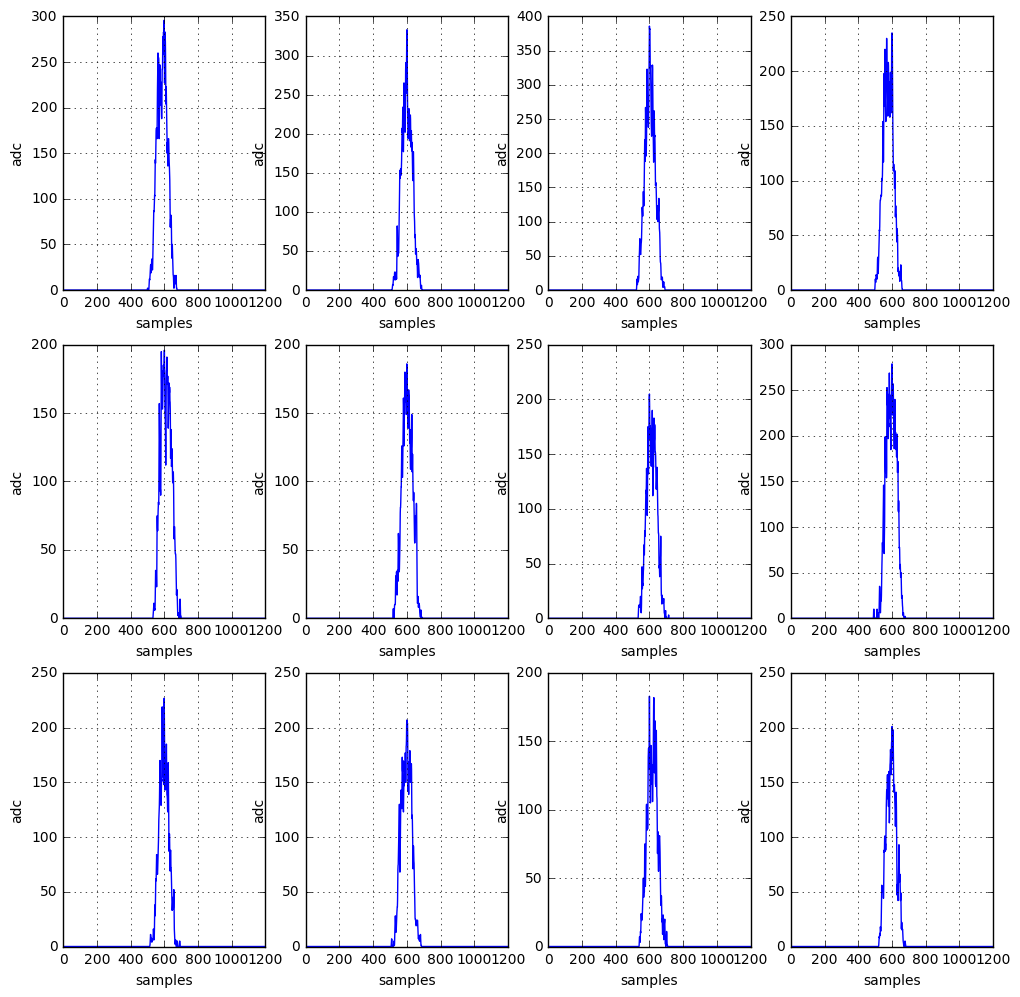

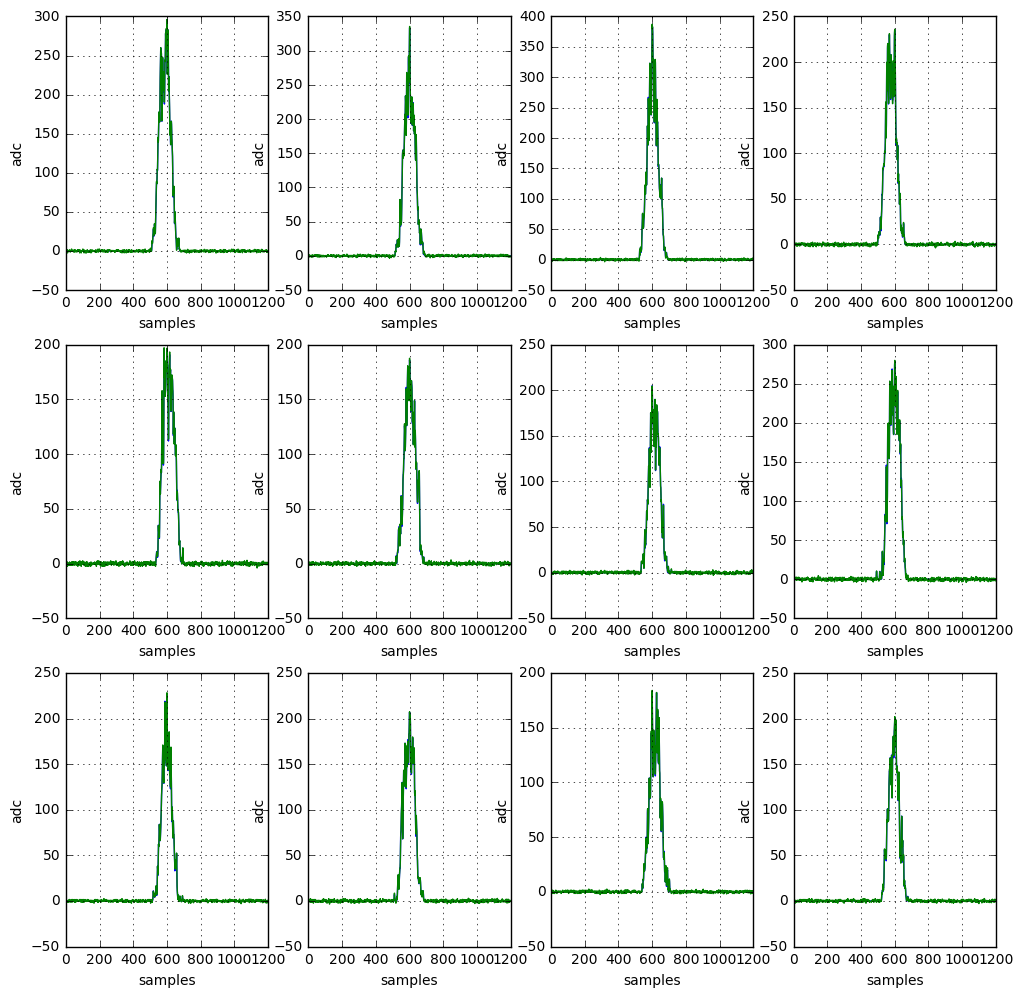

In [17]:
diff = diomira_cwf_blr(RWF_file, n_evt=1, plot=True)

The set of plots above show, for one event:
1. The RWFs for each PMT, where the effect of the HPF is evident (the RWF are negative in sign and with a baseline at ~2500 adc counts, to emulate the behaviour of the DAQ in real data).
2. The BLR functions, which only include the effect of the LPF (no distortion).
3. The CWF (in green) superimposed to the BLR (one cannot disitinguish one from the other)

In [18]:
def plot_cwf_blr(ffile, event, pmt, xi=4900, xf=5200):
    """Draw CWF and BLR waveform togethers for selected event and pmt %.
    """
    e40rwf= tb.open_file(ffile,'r+')
    pmtrwf = e40rwf.root.RD.pmtrwf
    pmtblr = e40rwf.root.RD.pmtblr
    DataPMT = load_db.DataPMT(0)
    coeff_c = DataPMT.coeff_c.values.astype(np.double)
    coeff_blr = DataPMT.coeff_blr.values.astype(np.double)
    
        
    
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                     n_baseline=28000, thr_trigger=5)
        
    plt.plot(pmtblr[event,pmt][xi:xf])
    plt.plot(CWF[pmt][xi:xf])
        
    plt.show()
            

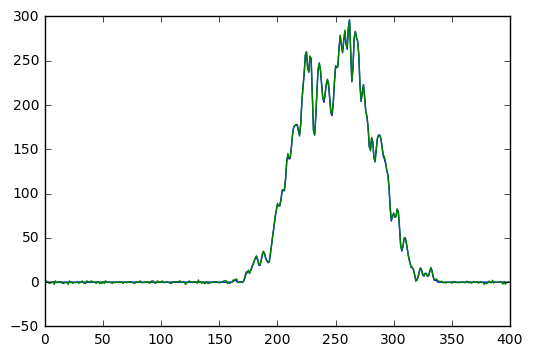

In [19]:
plot_cwf_blr(RWF_file, event=0, pmt=0, xi=4800, xf=5200)

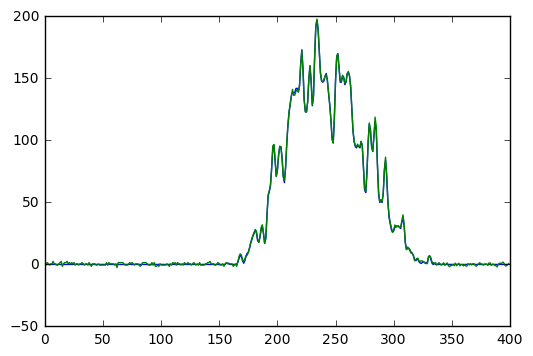

In [20]:
plot_cwf_blr(RWF_file, event=9, pmt=11, xi=4800, xf=5200)

The two examples above show the BLR and CWF wavefroms superimposed for two different events and two different PMTs. In both cases the eye cannot distinguish between both waveforms.

## Tracking plane

The tracking plane of NEW has 1792 SiPMs arranged in boards of 8x8 sensors. The SiPMs FEE runs at 1 MHz, providing one sample per microsecond.

The simulatin of the SiPms is very simple. Each MCRD contains the true number of pes in the sensor. Then, for each sensor, gaussian noise (corresponding to electronics and sensor thermal noise) and dark current noise is added. This is done through a SiPm noise sampler class, which stores the pdf of the noise in each sensor (measured from data) and returns a sample of this pdf each time that is invoked. 

In [21]:

e40rd = tb.open_file(MCRD_file,'r+')
NEVENTS_DST, NSIPM, SIPMWL = e40rd.root.sipmrd.shape

In [22]:
print('number of SiPM = {}, waveform length = {}'.format(NSIPM,SIPMWL))

number of SiPM = 1792, waveform length = 800


In [23]:
DataSiPM = load_db.DataSiPM(0)
sipm_adc_to_pes = DataSiPM.adc_to_pes.values.astype(np.double)

Conversion constants (number of adc counts per PES)

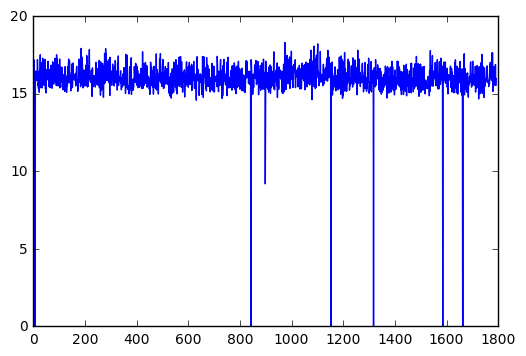

In [24]:
plt.plot(sipm_adc_to_pes)

### Nb
A few constants have values equal to zero, corresponding to dead SiPMs in the data. The average number of adc counts per pes is very flat (e.g, about the same for all SiPMs) and near 16. 

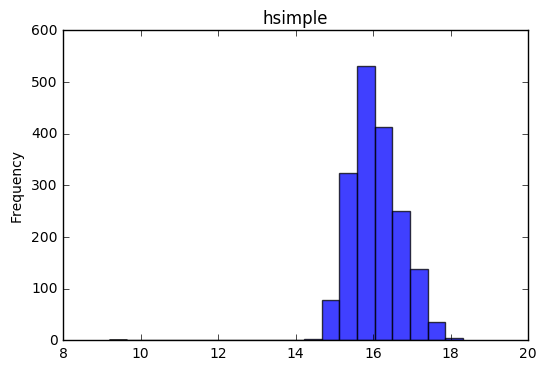

In [25]:
mpl.histo(sipm_adc_to_pes[sipm_adc_to_pes>0], nbins=20)

In [26]:
np.mean(sipm_adc_to_pes[sipm_adc_to_pes>0])

16.064245201793721

In [27]:
np.std(sipm_adc_to_pes[sipm_adc_to_pes>0])

0.64481931755475141

Thus, one pes corresponds to 16 adc counts with a small rms of ~0.6 counts.

### Simulation of the SiPM response

It is instructive to reproduce the simulation of the SiPM response from the MCRD, to study the dependence with noise.

In [28]:
def simulate_sipm_response(event, sipmrd, 
                           sipm_adc_to_pes,
                           sipms_noise_sampler):
        """Add noise with the NoiseSampler class and return
        the noisy waveform (in pes)."""
        # add noise (in PES) to true waveform
        dataSiPM = sipmrd[event] + sipms_noise_sampler.Sample()
        # return total signal in adc counts
        return wfm.to_adc(dataSiPM, sipm_adc_to_pes)

In [29]:
noise_sampler = SiPMsNoiseSampler(SIPMWL, True)

In [30]:
event=0
sipmrwf = simulate_sipm_response(event, 
                                 e40rd.root.sipmrd, 
                                 sipm_adc_to_pes,
                                 noise_sampler)

most of the SiPMs contain only noise

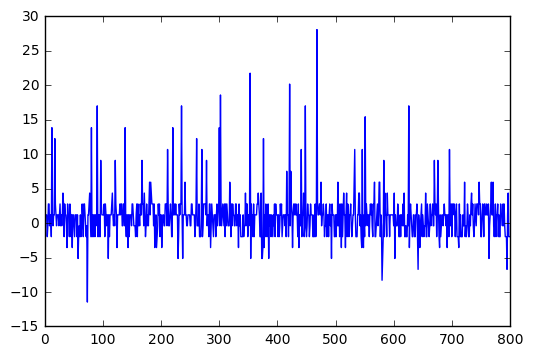

In [31]:
plt.plot(sipmrwf[0])

###  NB: 
The noise distribution has an rms of about 3 counts, with dark current at the level of 1-2 pes (~30 adc counts) superimposed. 

#### Find the SiPMs with signal

In [32]:
def sipm_with_signal(sipmrwf, thr=50):
    """Find the SiPMs with signal in this event"""
    SIPML = []
    for i in range(sipmrwf.shape[0]):
        if np.sum(sipmrwf[i] > thr):
            SIPML.append(i)
    return np.array(SIPML)

select sipms with more than 20 pes (e.g, 300 adc counts)

In [33]:
sipm_i = sipm_with_signal(sipmrwf, thr=300)

In [34]:
sipm_i

array([ 696,  767, 1024, 1095, 1331])

draw a map of SiPms with signal

In [35]:
def plot_ene_sipm(sipmrwf, sipm_i, radius=3):
        """
        plots the reconstructed energy of the SiPMs
        input: sipm dictionary
        """
        xs = DataSiPM.X.values
        ys = DataSiPM.Y.values
        r = np.ones(len(xs)) * radius
        col = np.zeros(len(xs))
        for i in sipm_i:
            sipm = sipmrwf[i]
            col[i] = np.sum(sipm)

        plt.figure(figsize=(10, 10))
        plt.subplot(aspect="equal")
        mpl.circles(xs, ys, r, c=col, alpha=0.5, ec="none")
        plt.colorbar()

        plt.xlim(-198, 198)
        plt.ylim(-198, 198)

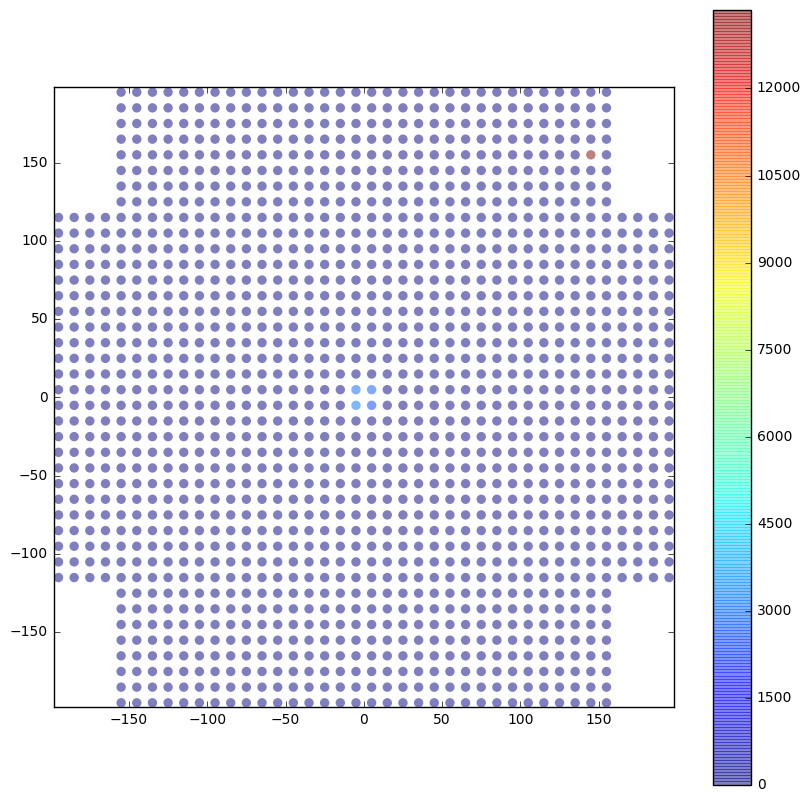

In [36]:
plot_ene_sipm(sipmrwf, sipm_i)

plot SiPMs with signal 

In [37]:
def plot_sipms(sipmrwf, sipm_i):
    """plot the waveforms of the SiPMs with signal."""
    nsipm = len(sipm_i)
    xw = 3
    yw = int(nsipm/xw) + 1
    plt.figure(figsize=(12, 12))
    for i, ni in enumerate(sipm_i):
        plt.subplot(xw, yw, i+1)
        mpl.set_plot_labels(xlabel="sipm = {}".format(ni), ylabel="adc")
        plt.plot(sipmrwf[ni])

    plt.show()

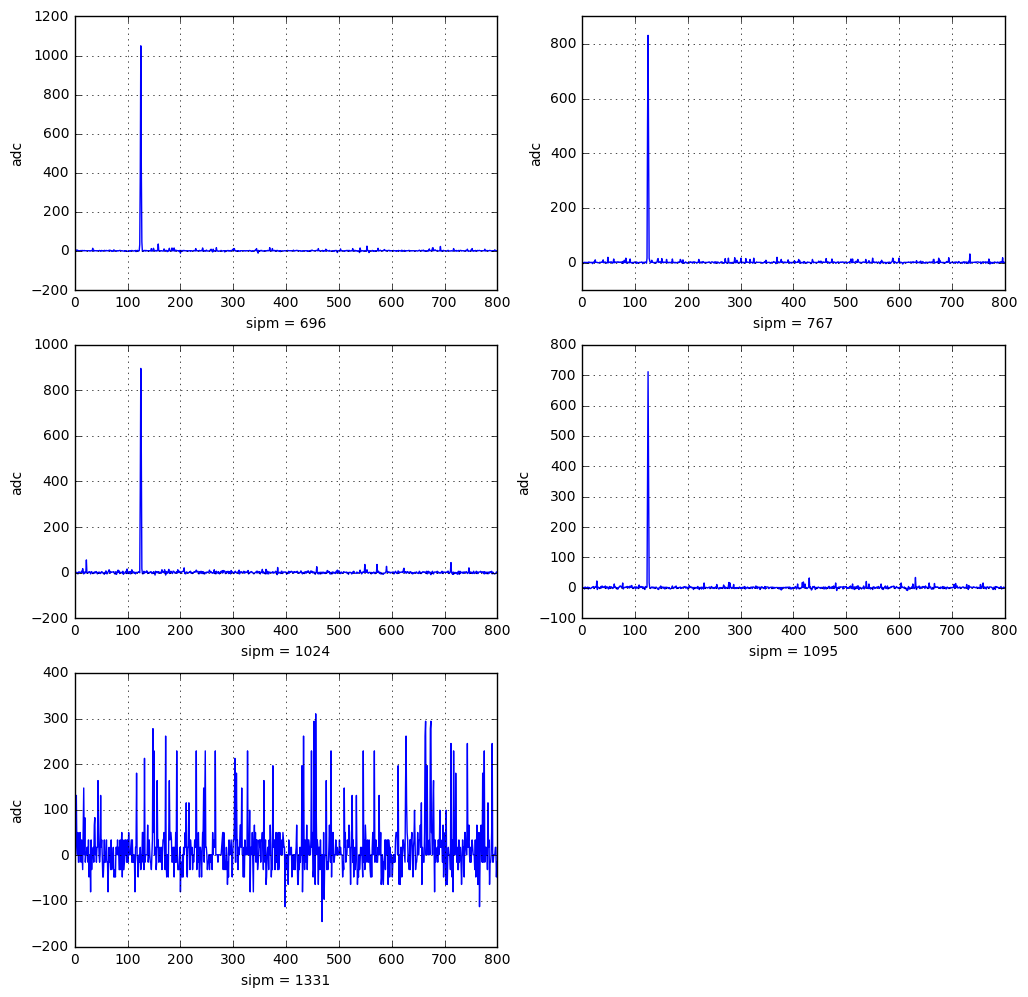

In [38]:
plot_sipms(sipmrwf, sipm_i)

In [39]:
esipm = np.array([np.sum(sipmrwf[i]) for i in sipm_i]) # in pes

In [40]:
print(esipm/16.) # in adc counts

[ 188.42876709  196.4055543   177.64683228  153.57869658  834.4864063 ]


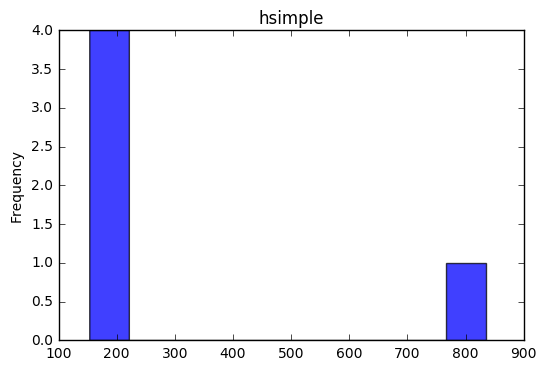

In [41]:
mpl.histo(esipm/16., nbins=10)

#### NB
We can see the noise bin separated from the signal bins. To exagerate the effect, on can reduce the energy cut, for example to 2 pes

In [42]:
sipm_i = sipm_with_signal(sipmrwf, thr=30)

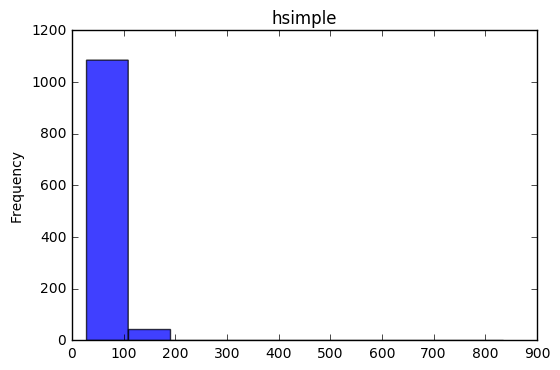

In [43]:
esipm = np.array([np.sum(sipmrwf[i]) for i in sipm_i])
mpl.histo(esipm[esipm>0]/16., nbins=10)

#### Noise suppression

In Diomira SiPms are stored after noise suppression. This is done as follows.

First define sipm thresholds (in adc counts). As shown a cut on 20 pes is good 

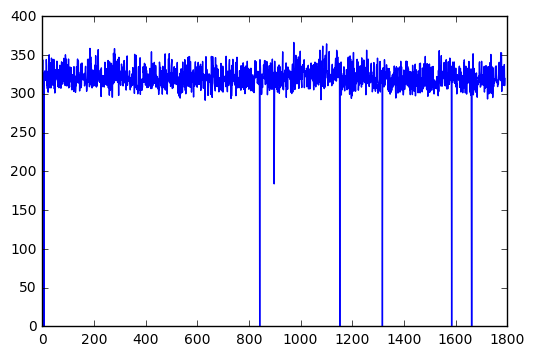

In [44]:
sipm_noise_cut = 20
sipms_thresholds = sipm_noise_cut *  sipm_adc_to_pes
plt.plot(sipms_thresholds)

Second compute the number of SiPMs above threshold

In [45]:
sipmzs = wfm.noise_suppression(sipmrwf, sipms_thresholds)

The sipmzs vector replaces by exact zeros those samples below threshold (this allows the compressor in pytables to save storage space). Thus, for example, the first sipm has no samples above threshold.

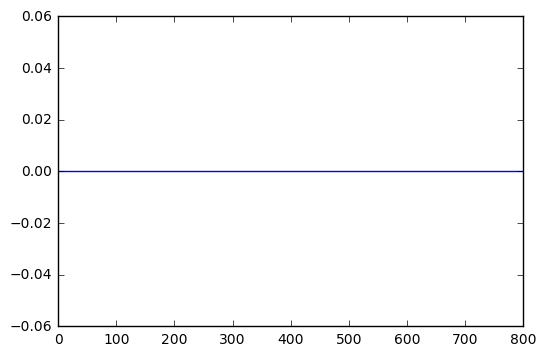

In [46]:
plt.plot(sipmzs[0])

while for sipm 696, we can see a clear signal above threshold. 

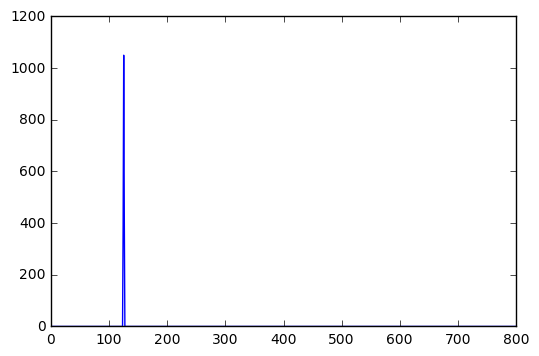

In [47]:
plt.plot(sipmzs[696])

In [48]:
def nof_sipm_signal(sipmzs):
    """Number of SiPms with signal in zs waveform"""
    nsipm = 0
    for j in range(sipmzs.shape[0]):
        if np.sum(sipmzs[j] >0):
            nsipm+=1
    return nsipm

In [49]:
print('number of sipm with signal = {}'.format(nof_sipm_signal(sipmzs)))

number of sipm with signal = 4


### Erase temporary file

In [50]:
try:
    os.system("rm -f {}".format(RWF_file))
except(IOError):
    pass

#### End of NB